In [ ]:
pip install yfinance pandas matplotlib numpy statsmodels seaborn

Note: you may need to restart the kernel to use updated packages.


In [ ]:
import yfinance as yf
import matplotlib.pyplot as plt

In [ ]:
#Download data 
data = yf.download(["BP", "SHEL"], start="2015-01-01", end="2020-01-01", auto_adjust=True)['Close']
bp = data['BP']
shell = data['SHEL']

[*********************100%***********************]  2 of 2 completed


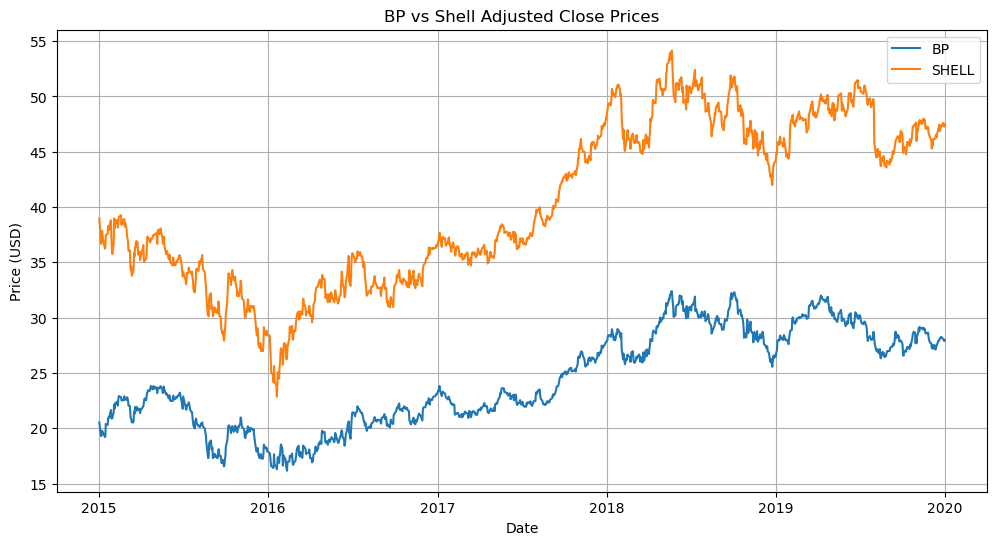

In [ ]:
#Plot
plt.figure(figsize=(12,6))
plt.plot(bp, label="BP")
plt.plot(shell, label="SHELL")
plt.title("BP vs Shell Adjusted Close Prices")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
#Using statistical testing to see if these stocks tend to move together long-term
from statsmodels.tsa.stattools import coint 

#Test for cointegration 
score, pvalue, _ = coint(bp, shell)
print("P-value: ", pvalue)

#p < 0.05 = strong evidence of cointegration

P-value:  0.0031926758161763243


Hedge ratio:  0.5782991492816197


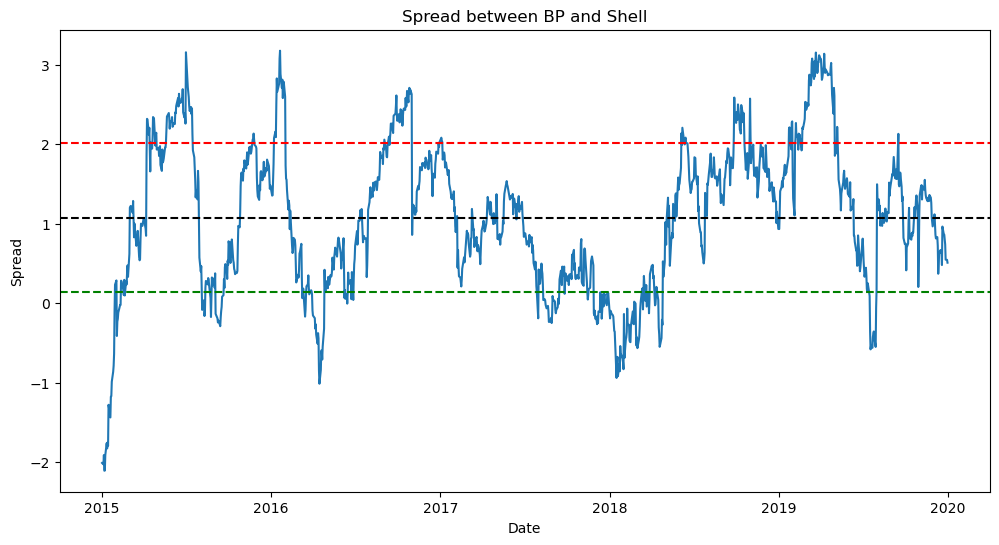

In [ ]:
import numpy as np

#Estimate hedge ratio using linear regression
import statsmodels.api as sm
X = sm.add_constant(shell)
model = sm.OLS(bp, X).fit()
hedge_ratio = model.params['SHEL']
print("Hedge ratio: ", hedge_ratio)

#Calculate spread
spread = bp - hedge_ratio * shell
spread_mean = spread.mean()
spread_std = spread.std()

#Plot spread
plt.figure(figsize=(12, 6))
plt.plot(spread)
plt.axhline(spread_mean, color='black', linestyle='--')
plt.axhline(spread_mean + spread_std, color='red', linestyle='--')
plt.axhline(spread_mean - spread_std, color='green', linestyle='--')
plt.title("Spread between BP and Shell")
plt.xlabel("Date")
plt.ylabel("Spread")
plt.show()

In [ ]:
signal = np.where(spread > spread_mean + spread_std, -1, #short spread
         np.where(spread < spread_mean - spread_std, 1, #long spread
         0)) #no trade

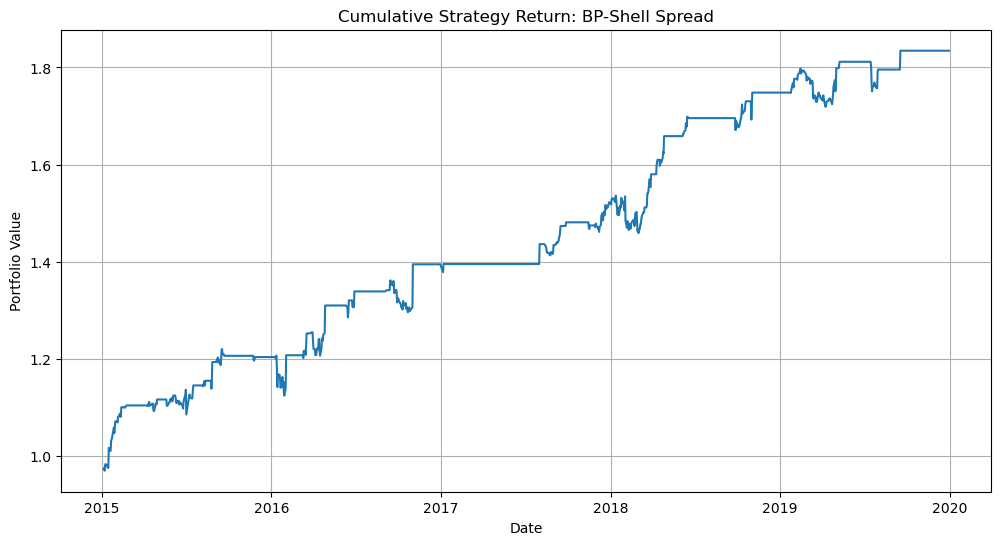

In [ ]:
bp_returns = bp.pct_change()
shell_returns = shell.pct_change()

#Strategy: long bp, short shell when signal = 1, opposite when -1, no trade when signal = 0
strategy_returns = signal[:-1] * (bp_returns[1:] - hedge_ratio * shell_returns[1:])

cumulative_returns = (1 + strategy_returns).cumprod()

#Plot cumulative returns 
plt.figure(figsize=(12,6))
plt.plot(cumulative_returns)
plt.title("Cumulative Strategy Return: BP-Shell Spread")
plt.xlabel("Date")
plt.ylabel("Portfolio Value")
plt.grid(True)
plt.show()

In [ ]:
def sharpe_ratio(returns):
    return np.mean(returns) / np.std(returns) + np.sqrt(252) #annualized

def max_drawdown(cum_returns):
    peak = cum_returns.cummax()
    drawdown = (cum_returns - peak) / peak 
    return drawdown.min()

print("Sharpe Ratio: ", sharpe_ratio(strategy_returns))
print("Max Drawdown: ", max_drawdown(cumulative_returns))
print("Total Return: ", cumulative_returns.iloc[-1] - 1)

Sharpe Ratio:  15.958903917022633
Max Drawdown:  -0.07871043620320209
Total Return:  0.8343606295543318


In [ ]:
import numpy as np
import pandas as pd

#Signal is a NumPy array, convert to Pandas series 
signal = pd.Series(signal)

#'Signal' is our z-score or spread signal, 'positions' is our trading signal
#Compute returns from signal
future_returns = signal.shift(-1) - signal #next day's return

#Drop NaNs
valid = signal.notna() & future_returns.notna()
signal = signal[valid]
future_returns = future_returns[valid]

#Calculate IC
information_coefficient1 = signal.corr(future_returns)

print(f"Information Coefficient From Signal: {information_coefficient1:.4f}")

Information Coefficient From Signal: -0.2482


In [ ]:
import numpy as np
import pandas as pd 

#Define positions: long when z < -1, short when z > 1, flat otherwise
positions = -np.sign(signal) #basic contrarian strategy

#Make sure 'positions' is a pandas Series 
positions = pd.Series(positions)

#Compute future return of the spread (spread_t+1 - spread_t)
future_returns = signal.shift(-1) - signal 

#Drop NaNs
valid = positions.notna() & future_returns.notna()
positions = positions[valid]
future_returns = future_returns[valid]

#Calculate IC
information_coefficient2 = positions.corr(future_returns)

print(f"Information Coefficient (positions vs future returns): {information_coefficient2:.4f}")

Information Coefficient (positions vs future returns): 0.2482
